In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import json
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import time
import requests
from datetime import datetime
HEADERS = {'content-type': 'application/x-www-form-urlencoded', 'User-Agent': 'Mozilla'}
def GetStockData(stock, fromTime,toTime):

    url = f"https://finfo-api.vndirect.com.vn/v4/vnmarket_prices?sort=date&q=code:{stock}~date:gte:{fromTime}~date:lte:{toTime}&size=3650"
    res = requests.get(url, headers=HEADERS)
    data = pd.DataFrame(res.json()['data'])
    data = data.sort_values(by=['date'])
    return data
data_VNINDEX = GetStockData("VNINDEX","2014-11-11","2022-11-21")
data_test = GetStockData("VNINDEX","2022-11-21","2023-11-29")
data_VNINDEX_full = GetStockData("VNINDEX","2014-11-11","2023-11-29")
fig = go.Figure(data=[go.Candlestick(x=data_VNINDEX['date'],
                open=data_VNINDEX['open'],
                high=data_VNINDEX['high'],
                low=data_VNINDEX['low'],
                close=data_VNINDEX['close'])])

fig.show()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566 entries, 1565 to 0
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   code            1566 non-null   object 
 1   floor           1566 non-null   object 
 2   date            1566 non-null   object 
 3   time            1566 non-null   object 
 4   type            1566 non-null   object 
 5   open            1566 non-null   float64
 6   high            1566 non-null   float64
 7   low             1566 non-null   float64
 8   close           1566 non-null   float64
 9   change          1566 non-null   float64
 10  pctChange       1566 non-null   float64
 11  accumulatedVol  1566 non-null   float64
 12  accumulatedVal  1566 non-null   float64
 13  nmVolume        1566 non-null   float64
 14  nmValue         1566 non-null   float64
 15  ptVolume        1566 non-null   float64
 16  ptValue         1566 non-null   float64
 17  advances        1566 non-null   f

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_VNINDEX['close'].values.reshape(-1,1))

In [ ]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='sgd',
    loss='mean_squared_error'
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=25,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25
39/40 [============================>.] - ETA: 0s - loss: 0.0821

40/40 [==============================] - 7s 73ms/step - loss: 0.0820
Epoch 2/25
39/40 [============================>.] - ETA: 0s - loss: 0.0387

40/40 [==============================] - 2s 54ms/step - loss: 0.0386
Epoch 3/25
39/40 [============================>.] - ETA: 0s - loss: 0.0338

40/40 [==============================] - 2s 54ms/step - loss: 0.0338
Epoch 4/25
39/40 [============================>.] - ETA: 0s - loss: 0.0288

40/40 [==============================] - 3s 73ms/step - loss: 0.0288
Epoch 5/25
39/40 [============================>.] - ETA: 0s - loss: 0.0237

40/40 [==============================] - 2s 53ms/step - loss: 0.0238
Epoch 6/25
39/40 [============================>.] - ETA: 0s - loss: 0.0184

40/40 [==============================] - 3s 73ms/step - loss: 0.0183
Epoch 7/25
39/40 [============================>.] - ETA: 0s - loss: 0.0140

40/40 [==============================] - 2s 53ms/step - loss: 0.0140
Epoch 8/25
39/40 [============================>.] - ETA: 0s - loss: 0.0111

40/40 [==============================] - 2s 54ms/step - loss: 0.0111
Epoch 9/25
39/40 [============================>.] - ETA: 0s - loss: 0.0085

40/40 [==============================] - 2s 54ms/step - loss: 0.0085
Epoch 10/25
39/40 [============================>.] - ETA: 0s - loss: 0.0075

40/40 [==============================] - 2s 54ms/step - loss: 0.0075
Epoch 11/25
40/40 [==============================] - ETA: 0s - loss: 0.0072

40/40 [==============================] - 3s 63ms/step - loss: 0.0072
Epoch 12/25
39/40 [============================>.] - ETA: 0s - loss: 0.0074

40/40 [==============================] - 3s 63ms/step - loss: 0.0074
Epoch 13/25
39/40 [============================>.] - ETA: 0s - loss: 0.0065

40/40 [==============================] - 2s 54ms/step - loss: 0.0065
Epoch 14/25
39/40 [============================>.] - ETA: 0s - loss: 0.0065

40/40 [==============================] - 2s 54ms/step - loss: 0.0065
Epoch 15/25
39/40 [============================>.] - ETA: 0s - loss: 0.0064

40/40 [==============================] - 2s 54ms/step - loss: 0.0064
Epoch 16/25
39/40 [============================>.] - ETA: 0s - loss: 0.0059

40/40 [==============================] - 2s 54ms/step - loss: 0.0059
Epoch 17/25
39/40 [============================>.] - ETA: 0s - loss: 0.0061

40/40 [==============================] - 3s 72ms/step - loss: 0.0061
Epoch 18/25
39/40 [============================>.] - ETA: 0s - loss: 0.0058

40/40 [==============================] - 2s 54ms/step - loss: 0.0058
Epoch 19/25
39/40 [============================>.] - ETA: 0s - loss: 0.0062

40/40 [==============================] - 2s 54ms/step - loss: 0.0062
Epoch 20/25
39/40 [============================>.] - ETA: 0s - loss: 0.0058

40/40 [==============================] - 2s 54ms/step - loss: 0.0058
Epoch 21/25
39/40 [============================>.] - ETA: 0s - loss: 0.0060

40/40 [==============================] - 2s 53ms/step - loss: 0.0060
Epoch 22/25
40/40 [==============================] - ETA: 0s - loss: 0.0060

40/40 [==============================] - 3s 64ms/step - loss: 0.0060
Epoch 23/25
39/40 [============================>.] - ETA: 0s - loss: 0.0057

40/40 [==============================] - 3s 63ms/step - loss: 0.0057
Epoch 24/25
39/40 [============================>.] - ETA: 0s - loss: 0.0056

40/40 [==============================] - 2s 54ms/step - loss: 0.0056
Epoch 25/25
39/40 [============================>.] - ETA: 0s - loss: 0.0054

40/40 [==============================] - 2s 54ms/step - loss: 0.0054


['.config', 'sample_data']


In [ ]:
# Extract the actual closing prices from the test data
actual_prices = data_test['close'].values
# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data_VNINDEX['close'], data_test['close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(data_test) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

print(f"Root mean squared error: {np.sqrt(mean_squared_error(actual_prices,predicted_prices))}")
print(f"Mean absolute error: {mean_absolute_error(actual_prices,predicted_prices)}")

8/8 [==============================] - 0s 15ms/step
Mean squared error: 39.50958654831315
Mean absolute error: 31.63797194480896


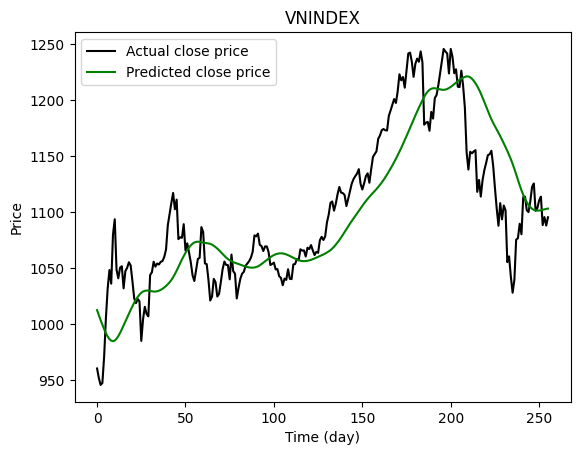

In [ ]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual close price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted close price")

# Set the title of the plot using the company name
plt.title(f"VNINDEX")

# Set the x-axis label as 'time'
plt.xlabel("Time (day)")

# Set the y-axis label using the company name
plt.ylabel(f"Price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [ ]:
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['.config', 'my_model.h5', 'my_model.keras', 'checkpoints', 'sample_data']

In [ ]:
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>